Objective of this jupyter notebook is to explore how to create a heat map of the player movement in a round. What would result out of it is a good idea of the map control the Gentle Mates acquires and at what time.

- How : Object Detection in the map 
    -> Gather Data of a map
    -> Label the data
    -> train model with roboflow


In [ ]:
!pip install roboflow

In [36]:
from roboflow import Roboflow

def load_model():
    rf = Roboflow(api_key="xEb6a3dXc9T0RuJ5Qnox")
    project = rf.workspace().project("valorant-heat-map")
    model = project.version(2).model
    return model

model = load_model()

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# infer on a local image
model.predict("heatmaps_data/round3_lotus.mp4", confidence=40, overlap=30).save("prediction.mp4")

In [ ]:
!pip install moviepy

In [39]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import os

def video_to_images(input_video, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the video clip
    video_clip = VideoFileClip(input_video)

    # Get the frames at a rate of 1 frame per second
    frames = video_clip.iter_frames(fps=1, dtype="uint8")

    # Save each frame as an image
    for i, frame in enumerate(frames):
        image_path = os.path.join(output_folder, f"frame_{i + 1:04d}.png")
        video_clip.save_frame(image_path, t=i)

    # Close the video clip
    video_clip.reader.close()

# Example usage:
video_path = "heatmaps_data/round3_lotus.mp4"
output_folder_path = "heatmaps_data/round3_lotus_images"

video_to_images(video_path, output_folder_path)

In [45]:
def get_file_names_in_folder(folder_path):
    """
    Get a list of all file names in a folder.
    
    Parameters:
    - folder_path (str): The path to the folder.

    Returns:
    - List[str]: A list of file names in the folder.
    """
    file_names = []
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            file_names.append(filename)
    return file_names

def evaluation(model, paths_to_images):
    
    report = []
    for i,image in enumerate(paths_to_images):
        print(f'{i} ---> {len(paths_to_images)}')
        report.append(model.predict("heatmaps_data/round3_lotus_images/" + image, confidence=40, overlap=30).json())
    
    return report

In [46]:
report = evaluation(model, get_file_names_in_folder("heatmaps_data/round3_lotus_images/"))

In [ ]:
report

In [ ]:
!pip install matplotlib
!pip install cv2
!pip install numpy
!pip install PIL

In [ ]:
report[0].get('predictions', [])

In [54]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

def show_heatmaps_from_report(report):
    
    for item in report:
        predictions = item.get('predictions', [])

        for prediction in predictions:
            class_name = prediction['class']
            if class_name not in ['DFS', 'ATK']:
                continue  # Skip classes other than 'DFS' and 'ATK'

            image_path = prediction['image_path']
            image = cv2.imread(image_path)

            # Create a figure and axes
            fig, ax = plt.subplots(1)
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Extract bounding box coordinates
            x, y, width, height = prediction['x'], prediction['y'], prediction['width'], prediction['height']

            # Create a rectangle patch
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the rectangle to the Axes
            ax.add_patch(rect)

            # Display class and confidence
            ax.text(x, y - 5, f'{class_name} - {prediction["confidence"]:.2f}', color='r')

            # Show the plot
            plt.show()

In [ ]:
show_heatmaps_from_report(report, "")

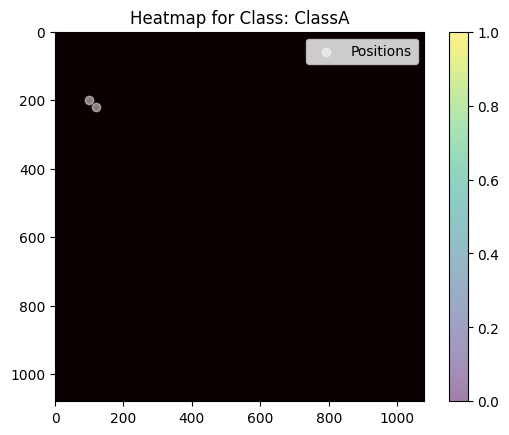

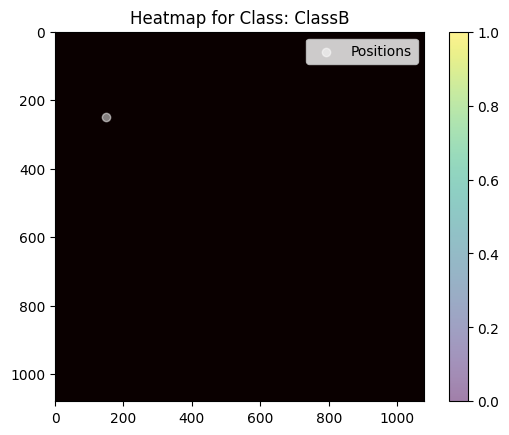

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def create_heatmap(coordinates):
    # Extract unique classes
    unique_classes = set(coord['class'] for coord in coordinates)

    # Initialize a dictionary to store counts for each class
    class_counts = {cls: np.zeros((1080, 1080)) for cls in unique_classes}

    # Loop through coordinates and accumulate counts
    for coord in coordinates:
        x, y, cls = coord['x'], coord['y'], coord['class']
        class_counts[cls][y, x] += 1  # Note the reversed y, x for image coordinates

    # Plot heatmaps for each class
    for cls, counts in class_counts.items():
        plt.imshow(counts, cmap='hot', interpolation='nearest', origin='upper')

        # Scatter plot with increased alpha for better visibility
        plt.scatter([], [], c='w', marker='o', label='Positions', alpha=0.5)

        plt.title(f'Heatmap for Class: {cls}')
        plt.colorbar()

        # Show scatter plot of positions
        positions_x, positions_y = np.where(class_counts[cls] > 0)
        plt.scatter(positions_y, positions_x, c='w', marker='o', alpha=0.5)

        plt.legend()
        plt.show()

# Example usage:
coordinates = [
    {'x': 100, 'y': 200, 'class': 'ClassA', 'time': 0},
    {'x': 150, 'y': 250, 'class': 'ClassB', 'time': 0},
    {'x': 120, 'y': 220, 'class': 'ClassA', 'time': 1},
    # Add more coordinates as needed
]

create_heatmap(coordinates)